In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('train_trans.csv')
y_train = X_train['FLAG']
X_val = pd.read_csv('val_trans.csv')
y_val = X_val['FLAG']
X_test = pd.read_csv('test_trans.csv')
y_test = X_test['FLAG']

In [3]:
X_train.drop(columns=['Unnamed: 0','FLAG'], inplace = True) # drop the first two columns
X_val.drop(columns=['Unnamed: 0','FLAG'], inplace = True)
X_test.drop(columns=['Unnamed: 0','FLAG'], inplace = True)

Generate Validation Set from X_train

In [4]:
def model_eval(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true,predicted).ravel()
    print(confusion_matrix(true,predicted))
    print('tn = ' + str(tn), 'fp = ' + str(fp),'fn = ' + str(fn),'tp = ' + str(tp))
    print(classification_report(true,predicted))


In [5]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, recall_score

## XGBoost Testing

In [6]:
from xgboost import XGBClassifier

In [7]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)
train_pred = xgb.predict(X_train)
model_eval(y_train, train_pred)

[[6205    0]
 [   0 1765]]
tn = 6205 fp = 0 fn = 0 tp = 1765
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6205
           1       1.00      1.00      1.00      1765

    accuracy                           1.00      7970
   macro avg       1.00      1.00      1.00      7970
weighted avg       1.00      1.00      1.00      7970



In [8]:
val_pred = xgb.predict(X_val)
model_eval(val_pred, y_val)

[[683   7]
 [  7 189]]
tn = 683 fp = 7 fn = 7 tp = 189
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       690
           1       0.96      0.96      0.96       196

    accuracy                           0.98       886
   macro avg       0.98      0.98      0.98       886
weighted avg       0.98      0.98      0.98       886



## Hyperparameter Tuning

In [9]:
%%time
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,140,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.randint('n_estimators', 180)
    }


CPU times: total: 797 ms
Wall time: 421 ms


In [13]:
%%time
def objective(space):
    xgb = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),reg_lambda = space['reg_lambda'], early_stopping_rounds = 10, eval_metric = 'auc')
    xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False)
    pred = xgb.predict(X_val)
    accuracy = f1_score(y_val, pred)
    return{'loss':-accuracy, 'status': STATUS_OK}

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
%%time
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

100%|█████████████████████████████████████████████| 300/300 [00:53<00:00,  5.60trial/s, best loss: -0.9251336898395722]
CPU times: total: 6min 11s
Wall time: 53.6 s


In [17]:
best_hyperparams
xgb2 = XGBClassifier(colsample_bytree = best_hyperparams['colsample_bytree'], gamma = best_hyperparams['gamma'],
                    max_depth = 9, min_child_weight = best_hyperparams['min_child_weight'],
                     reg_alpha = best_hyperparams['reg_alpha'], reg_lambda = best_hyperparams['reg_lambda'], n_estimators = 114 )
xgb2.fit(X_train, y_train)
train_pred = xgb2.predict(X_train)
model_eval(y_train, train_pred)

[[6178   27]
 [ 110 1655]]
tn = 6178 fp = 27 fn = 110 tp = 1655
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6205
           1       0.98      0.94      0.96      1765

    accuracy                           0.98      7970
   macro avg       0.98      0.97      0.97      7970
weighted avg       0.98      0.98      0.98      7970



In [16]:
best_hyperparams

{'colsample_bytree': 0.8905231973043986,
 'gamma': 7.590187609886593,
 'max_depth': 9.0,
 'min_child_weight': 4.0,
 'n_estimators': 114,
 'reg_alpha': 7.0,
 'reg_lambda': 0.4453051273037513}

In [18]:
val_pred = xgb2.predict(X_val)
model_eval(y_val, val_pred)

[[684   6]
 [ 10 186]]
tn = 684 fp = 6 fn = 10 tp = 186
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       690
           1       0.97      0.95      0.96       196

    accuracy                           0.98       886
   macro avg       0.98      0.97      0.97       886
weighted avg       0.98      0.98      0.98       886



Evaluating model on test data

In [19]:
test_pred = xgb2.predict(X_test)
model_eval(test_pred, y_test)

[[761  15]
 [  6 203]]
tn = 761 fp = 15 fn = 6 tp = 203
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       776
           1       0.93      0.97      0.95       209

    accuracy                           0.98       985
   macro avg       0.96      0.98      0.97       985
weighted avg       0.98      0.98      0.98       985



In [20]:
d = pd.DataFrame({'features': xgb2.feature_names_in_, 'weights': xgb2.feature_importances_})
importance = d.sort_values(by = ['weights'], ascending = False)[:20]
importance

,features,weights
58,ERC-20 info all NA_0,0.383981
37,ERC20_most_rec_token_type_Blockwell say NOTSAFU,0.221760
42,ERC20_most_rec_token_type_GSENetwork,0.077354
2,Time Diff between first and last (Mins),0.042440
15,ERC20 uniq rec token name,0.034391
41,ERC20_most_rec_token_type_Free BOB Tokens - B...,0.034215
11,ERC20 uniq rec addr,0.028220
4,Unique Received From Addresses,0.015406
3,Sent tnx,0.014268
12,ERC20 min val rec,0.011017


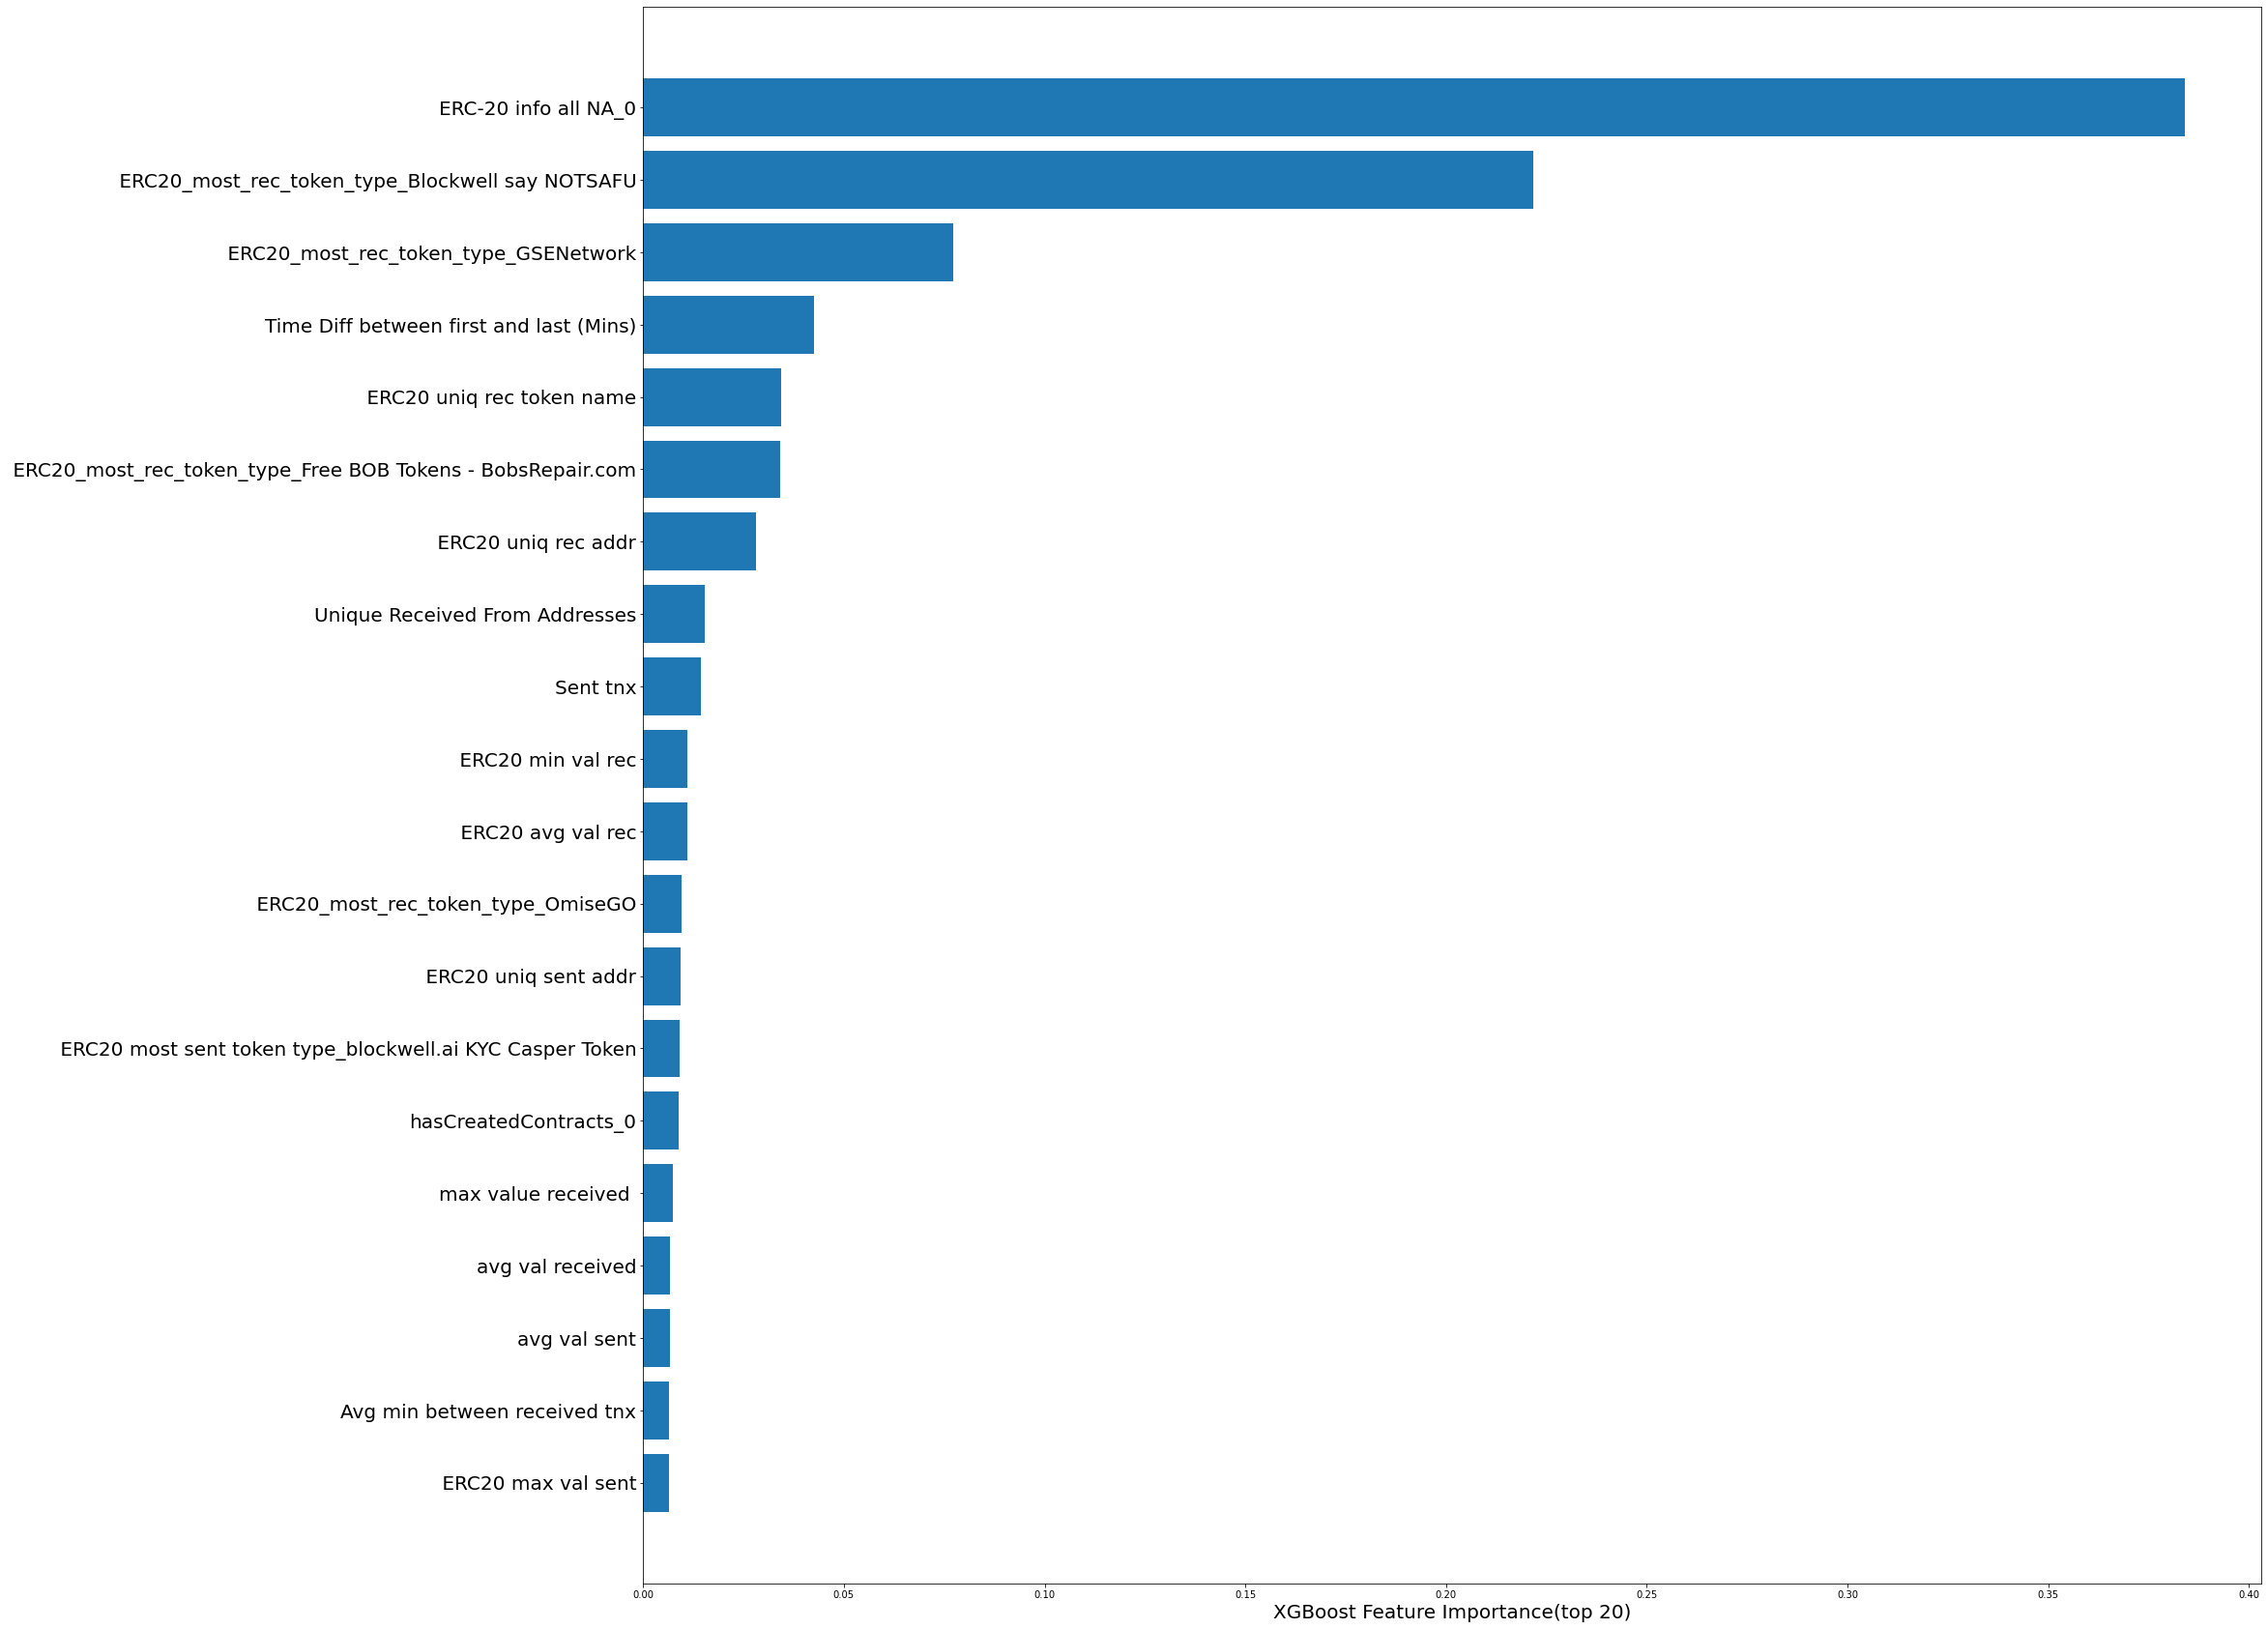

In [21]:
fig, axes = plt.subplots(figsize=(30,30))
plt.barh(importance['features'][::-1],importance['weights'][::-1])
plt.xlabel("XGBoost Feature Importance(top 20)", fontdict={'size':20})
plt.yticks(font={'size':20})
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


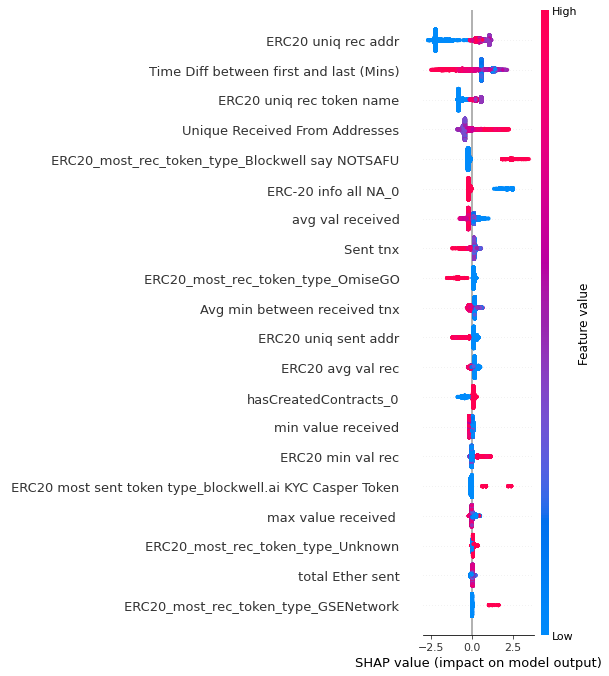

In [22]:
import shap
explainer = shap.TreeExplainer(xgb2)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)